# Fraud Prediction at Electronica 
## Part 2: Deployable Feature Engineering and Logistic Regression Algorithm


This outputs a machine learning model that predicts the probability 
that the first transaction of a new user is fraudulent.

If you fail to identify a fraudulent transaction, 
Electronica loses money equivalent to the price of the fraudulently purchased product. 

If you incorrectly flag a real transaction as fraudulent, 
it inconveniences the Electronica customers whose valid transactions are flagged—a cost your client values at $8.

    Created by Edwin Campos on 2020 Feb.18
    Last modification on 2020 Feb.19 by ecampos.phd@gmail.com


In [1]:
# Optional: Clean the memory
%reset -s

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Dependencies

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, f1_score
import itertools
from sklearn.metrics import confusion_matrix

In [25]:
import numpy as np

### Global Variables

In [15]:
INPUT_PATH = '/Users/ecampos/AnacondaProjects/DS-Fraud-Univar/Fraud - For Candidate/Fraud - For Candidate/'
INPUT_FILE = 'fraud.csv'
IP2COUNTRY_FILE = 'IpAddress_to_Country.csv'
TARGET = 'class'   # Column in dataframe with target values, Fraud:1, Good:0
MODEL_FILENAME = 'fraud_model_logistic_reg.sav' #'fraud_model_logisticRegression.sav'

### Method to convert from ip address into country

In [4]:
def convert_ip2country(ip_number_df,lookup_df):
    """Outputs the country where the numeric IP address is located.
    Call it as...
        convert_ip2country(df_all, df_ip2country)
    Inputs:
       ip_number_df -- Pandas Dataframe or Series with numeric values corresponding to an Internet Protocol address 
                       For example ips_df = pd.Series({'ip_address':[16777216,16777210.0]})
       lookup_df -- Pandas Dataframe name with information to map an IP address to its country
    Output:
       output_df -- Pandas Series with the country name of each IP address
    """
    #Initialize output dataframe
    output_df = pd.DataFrame(columns=['ip_address'])
    for ip_number in ip_number_df['ip_address']:
        lookup_df_1 = lookup_df[ lookup_df['lower_bound_ip_address'] <= ip_number ]
        if lookup_df_1.empty:
            country = 'ErrorTooLowIP'
        else:
            lookup_df_2 = lookup_df_1[lookup_df_1['upper_bound_ip_address'] >= ip_number]
            if lookup_df_2.empty:
                country = 'ErrorTooHighIP'
            else:
                country = lookup_df_2['country'].iloc[0]
        output_df = output_df.append({'ip_address': country }, ignore_index=True)
    
    return output_df

### Feature Engineering Method

In [5]:
def engineer_features(input_csv, target_column, ip2country_file, impute=False):
    """Builds the features for the Electronica Fraud model
    Call it as...
        X_test, y_test = engineer_features(INPUT_PATH+INPUT_FILE, TARGET, INPUT_PATH+IP2COUNTRY_FILE)
    Inputs: 
        input_csv -- string path to input dataset, for example, INPUT_PATH+INPUT_FILE
        target_column -- string with column name of target variable, for example, TARGET
        ip2country_file -- file with the CSV lookup table to match IP addresses to its countries, for example, INPUT_PATH+IP2COUNTRY_FILE
        impute -- Optional indtruction to whether or not impute missing values, for example, True, False, or None
    Outputs: 
        X_t with model input-feature values and y_t with model target values
    """
    # Ingest Input dataset
    df_all = pd.read_csv(input_csv, low_memory=False)
    
    # Impute Missing values: If Nan, then make it zero and create a flag column accordingly
    if impute:
        print("Missing values will be inputed.")
        columns2impute = df_all.columns
        for col in columns2impute:
            df_all[col+'_flag']=np.where(df_all[col].isnull()==True,1,0)
        df_all = df_all.fillna(0)
    
    # Convert from Dates and Times into Seconds since Epoch
    df_all['signup_datetime'] = pd.to_datetime(df_all['signup_time'])
    df_all['signup_epoch'] = (df_all['signup_datetime'] - dt.datetime(1970,1,1)).dt.total_seconds()
    df_all['purchase_datetime'] = pd.to_datetime(df_all['purchase_time'])
    df_all['purchase_epoch'] = (df_all['purchase_datetime']  - dt.datetime(1970,1,1)).dt.total_seconds()
    
    # Create new column features for days of week and period between signup and first purchase
    # days_name = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    df_all['signup_dayofweek'] = df_all['signup_datetime'].dt.dayofweek
    df_all['purchase_dayofweek'] = df_all['purchase_datetime'].dt.dayofweek
    df_all["purchase_signup_epoch"] = (df_all['purchase_epoch'] - df_all['signup_epoch'])
    
    # Removing Non-Word Characters (% @ " ? % $) using Regular Expressions
    df_all['purchase_value_numeric'] = df_all['purchase_value'].replace(r"[@\'?\$%_]", "", regex=True).apply(pd.to_numeric, errors='raise')
    
    # Ingest dataset with lookup table
    df_ip2country = pd.read_csv(ip2country_file)
    
    # Create additional column with ip_country
    df_all['ip_country'] = convert_ip2country(df_all, df_ip2country )
    
    # Remove special characters from ip_country column
    df_all['ip_country_clean'] = df_all['ip_country'].str.replace('\W', '')
    
    # Apply One-Hot-Encoding to columns ip_country, source, browser, and sex
    onehotencoding_columns = ['ip_country_clean','source', 'browser', 'sex']  # On column 'source', SEO corresponds to Search Engine Optimization
    for col in onehotencoding_columns:
        df_dummies = pd.get_dummies(df_all[col], prefix = col)
        df_all = pd.concat([df_all, df_dummies], axis=1)
        
    # Identify features and target columns
    unwanted_columns = ['signup_epoch',  # Redundant as per Covariance Matrix
                        'Unnamed: 0', 'user_id', 'device_id',  # irrelevant or random at moment of using model
                        'signup_time', 'purchase_time', 'purchase_value', #other numeric columns were created instead
                        'ip_country','ip_country_clean', # Other One-hot-encoded columns created instead
                        'source', 'browser', 'sex',  # Other One-hot-encoded columns created instead
                        'signup_datetime', 'purchase_datetime'  # Other numeric columns created instead
                       ]
    unwanted_columns.append(target_column)
    feature_columns =[x for x in df_all.columns if x not in unwanted_columns]
    X_t = df_all[feature_columns]
    y_t = df_all[TARGET]    
    
    return X_t, y_t

### Method to calculate money lost by Electronica due to model output errors

In [6]:
def custom_loss(y_target, y_predict, X_input):
    """Calculates the average dollars lost per wrong prediction, for the Electronica Fraud model
    Call it as
        custom_loss( X_input=X_test, y_target=y_test, y_predict=y_pred_test )
    Inputs: 
        y_target -- True target values
        y_predict -- Target values predicted by the model
        X_input -- Model input-feature values
    Outputs:
        ratio = amount of dollars lost by model errors / number of predictions done by model
    """
    error = 0
    #for i in range(y_target.shape[0]):  # Use this for Pandas
    for i in range(len(y_target)):
        #False Negatives
        #if (y_predict.iloc[i].item() == 0) and (y_target.iloc[i].item() == 1):  # Use this for Pandas
        if (y_predict[i] == 0) and (y_target[i] == 1):                           # Use this for Numpy
            error_i = X_input.purchase_value_numeric.iloc[i]          
        #False Positives
        #elif y_predict.iloc[i].item() == 1 and y_target.iloc[i].item() == 0:    # Use this for Pandas
        elif y_predict[i] == 1 and y_target[i] == 0:     # Use this for Numpy
            error_i = 8
        else:
            error_i = 0
        error += error_i
    return error/len(y_target)

custom_scorer = make_scorer(custom_loss, greater_is_better=False)

### Method to plot the confusion matrix

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This Procedure generates a matplotlib object to be used in a confusion matrix image.
    Use it as...
        plot_confusion_matrix(conf_matrix_test, 
                              classes=['0:Good','1:Fraud'], 
                              title="Test Confusion Matrix, Counts")
        plt.figure()
        plt.show
    Inputs:
        cm -- confusion matrix values
        classes -- Strings to be used as labels next to plot axes tickmarks, corresponding to each target class
        title -- Strings with the plot title
    output:
        plt -- A matplotlib object
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,int(round(cm[i,j])),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Main code

In [8]:
# This can take ~17 min running
X_test, y_test = engineer_features(INPUT_PATH+INPUT_FILE, TARGET, INPUT_PATH+IP2COUNTRY_FILE)

In [14]:
print(X_test.shape)   
feature_columns =[x for x in X_test.columns]
print('Model Features:', feature_columns)

(120000, 196)
Model Features: ['age', 'ip_address', 'purchase_epoch', 'signup_dayofweek', 'purchase_dayofweek', 'purchase_signup_epoch', 'purchase_value_numeric', 'ip_country_clean_Afghanistan', 'ip_country_clean_Albania', 'ip_country_clean_Algeria', 'ip_country_clean_Angola', 'ip_country_clean_AntiguaandBarbuda', 'ip_country_clean_Argentina', 'ip_country_clean_Armenia', 'ip_country_clean_Australia', 'ip_country_clean_Austria', 'ip_country_clean_Azerbaijan', 'ip_country_clean_Bahamas', 'ip_country_clean_Bahrain', 'ip_country_clean_Bangladesh', 'ip_country_clean_Barbados', 'ip_country_clean_Belarus', 'ip_country_clean_Belgium', 'ip_country_clean_Belize', 'ip_country_clean_Benin', 'ip_country_clean_Bermuda', 'ip_country_clean_Bhutan', 'ip_country_clean_Bolivia', 'ip_country_clean_BosniaandHerzegowina', 'ip_country_clean_Botswana', 'ip_country_clean_Brazil', 'ip_country_clean_BritishIndianOceanTerritory', 'ip_country_clean_BruneiDarussalam', 'ip_country_clean_Bulgaria', 'ip_country_clean_

In [16]:
loaded_model = pickle.load(open(MODEL_FILENAME, 'rb'))
result = loaded_model.score(X_test, y_test)

print(result)

print(classification_report(y_test, 
                            loaded_model.predict(X_test)
                           ))

0.6461166666666667
              precision    recall  f1-score   support

           0       0.95      0.64      0.77    108735
           1       0.17      0.70      0.27     11265

   micro avg       0.65      0.65      0.65    120000
   macro avg       0.56      0.67      0.52    120000
weighted avg       0.88      0.65      0.72    120000



In [20]:
print(X_test.shape, loaded_model.coef_.shape)
#print(X_test.shape, loaded_model.best_estimator_.coef_.shape)

print(TARGET+' =')
for i in range(X_test.shape[1]):
    print( loaded_model.coef_[0][i],'*',X_test.columns[i] )
    if i != X_test.shape[1]:
        print('+')

(120000, 196) (1, 196)
class =
1.0118178667593735e-13 * age
+
-7.335148786511978e-12 * ip_address
+
6.792518882711449e-10 * purchase_epoch
+
3.475082942890601e-14 * signup_dayofweek
+
5.1893981351900585e-14 * purchase_dayofweek
+
-2.5605414722768513e-07 * purchase_signup_epoch
+
1.8421064668310028e-13 * purchase_value_numeric
+
4.183948417574122e-18 * ip_country_clean_Afghanistan
+
-2.1775033311371763e-17 * ip_country_clean_Albania
+
1.677015194138587e-16 * ip_country_clean_Algeria
+
0.0 * ip_country_clean_Angola
+
0.0 * ip_country_clean_AntiguaandBarbuda
+
5.251271035012678e-16 * ip_country_clean_Argentina
+
6.779241179570575e-17 * ip_country_clean_Armenia
+
-1.3692184460304211e-16 * ip_country_clean_Australia
+
-3.316522292717106e-16 * ip_country_clean_Austria
+
2.745889839837999e-17 * ip_country_clean_Azerbaijan
+
0.0 * ip_country_clean_Bahamas
+
-1.9835063387478663e-17 * ip_country_clean_Bahrain
+
0.0 * ip_country_clean_Bangladesh
+
-8.589362270203819e-18 * ip_country_clean_Barbado

### Drivers of fraudulent activity: the Features with the largest coefficient

    for the X_train.columns[i], 
    where index corresponds to the maximum value of grid_result.best_estimator_.coef_[0][*]

In [23]:
#Predict values based on new parameters
y_pred_test = loaded_model.predict(X_test)

# New Model Evaluation metrics
print('Custom Lost Function: $' + str(custom_loss(X_input=X_test, 
                                                  y_target=y_test, 
                                                  y_predict=y_pred_test)) )
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

# Confusion Matrix on test dataset
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix:')
print(conf_matrix_test)

Custom Lost Function: $3.65255
Accuracy Score : 0.6461166666666667
Precision Score : 0.16809565346892752
Recall Score : 0.7013759431868619
F1 Score : 0.2711951671586463
Confusion Matrix:
[[69633 39102]
 [ 3364  7901]]


[[69633 39102]
 [ 3364  7901]]
[[58.0275     32.585     ]
 [ 2.80333333  6.58416667]]


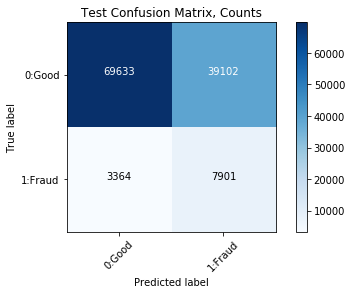

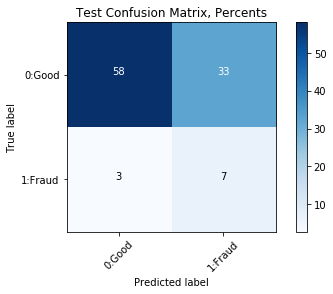

In [37]:
# Plot Confusion Matrix in counts
plt.figure() 
plot_confusion_matrix(conf_matrix_test, classes=['0:Good','1:Fraud'], 
                      title="Test Confusion Matrix, Counts")
#plt.figure()
#plt.show
plt.savefig('conf_matrix_counts_test.png')

# Plot Confusion Matrix in percents
plt.figure()
conf_matrix_test_percents = 100.0 * conf_matrix_test /float(len(y_test))
plot_confusion_matrix(conf_matrix_test_percents, classes=['0:Good','1:Fraud'],
                      title="Test Confusion Matrix, Percents")
plt.show
plt.savefig('conf_matrix_prcnts_test.png')

### Future Work -> This part is under construction

In [ ]:
POR ACA VOY

#### Compute Cross Validation using the area under the Receiver Operating Characteristic curve

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
MODEL = model_logistic_reg
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(MODEL, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

The code below is using Class Weighted XGBoost, or Cost-Sensitive XGBoost, which can offer better performance on binary classification problems with a severe class imbalance.

Reference: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = XGBClassifier(objective='binary:logistic', n_estimators=10, seed=21)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
predic = xg_cl.predict(X_test)
probab = xg_cl.predict_proba(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(predic==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

In [ ]:
# Define model: eXtreame Gradient Boosting
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, # Number of folds
                             n_repeats=3, # Number of times cross-validator will be repeated
                             random_state=1)  # For reproducible results
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

#### Future Work -- Using stratified cross validation to evaluate an XGBoost model.

If you have many classes for a classification type predictive modeling problem or the classes are imbalanced (there are a lot more instances for one class than another), it can be a good idea to create stratified folds when performing cross validation.

This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross validation evaluation. The scikit-learn library provides this capability in the StratifiedKFold class.

Reference: https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/

In [ ]:
# Define evaluation method: stratified k-fold cross validation evaluation of xgboost model
#from numpy import loadtxt
#import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
# Cross Validated model
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# Using Naive Bayes